# Прогнозирование оттока клиентов сети фитнес-центров «Культурист-датасаентист»

<br/>
    
<div class="alert alert-info">
<h2> Привет!<a class="tocSkip"></h2>
<hr>  
Я - Сергей. Рад что ты читаешь это текст :) Сделаю пару ремарок общего характера. В описании выполняемых действий, комментариях, я использую местоимение 'мы', так как считаю что ты - ревьювер, проверя код становиться моим соучастником ('соучавствующие программирование') и мы вместе проходим по пути исследования. Да и сформировлась привычка так писать в ходе написания научных работ.   
NB! - так помечаю важные на мой взгдял идеи, которые стоит взять на заметку; инсайты, проработка которых требует большего знания предметной области.   
Надеюсь мои многословные комментарии тебя не утомят.    
</div>
    
<br/>

**СОДЕРЖАНИЕ**    

[1  Описание проекта](#description)    
[2  Загрузка данных](#load)    
[3  Исследовательский анализ данных (EDA)](#eda)    
[3.1  Обзор данных](#review)    
[3.2  Сравнение оставшихся и ушедших клиентов](#churn)    
[3.3  Столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался](#churn_hist)    
[3.4  Матрица корреляций признаков](#corr)    
[3.5  Выводы](#summary_3)    
[4  Построение модели прогнозирования оттока пользователей](#model)    
[4.1  Выделение обучающей и валидационной выборок](#selection)    
[4.2  Обучение моделей](#training)    
[4.3  Оценка метрик и сравнение моделей](#metrics)    
[4.4  Выводы](#summary_4)    
[5  Кластеризация пользователей](#clustering)    
[5.1  Стандартизация данных](#standardization)    
[5.2  Построение матрицы расстояний и дендрограммы](#matrix)    
[5.3  Обучение модели кластеризации и прогноз кластеров клиентов](#clust_training)    
[5.4  Анализ распределения признаков для кластеров](#features)    
[5.5  Расчёт и анализ долей оттока для кластеров](#shares)    
[5.6  Выводы](#summary_5)    
[6  Выводы и рекомендации](#summary)    


## Описание проекта<a id="description"></a>       
    
Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.  
   
**Задачи:**  
1. научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;  
1. сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;  
1. проанализировать основные признаки, наиболее сильно влияющие на отток;  
1. сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:  
   * выделить целевые группы клиентов;  
   * предложить меры по снижению оттока;  
   * определить другие особенности взаимодействия с клиентами.   
   
**Описание данных**   
1. Данные клиента за предыдущий месяц до проверки факта оттока месяц:  
**gender** — пол;     
**Near_Location** — проживание или работа в районе, где находится фитнес-центр;   
**Partner** — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);   
**Promo_friends** — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);   
**Phone** — наличие контактного телефона;   
**Age** — возраст;   
**Lifetime** — время с момента первого обращения в фитнес-центр (в месяцах).   

2. Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:   
**Contract_period** — длительность текущего действующего абонемента (месяц, 6 месяцев, год);   
**Month_to_end_contract** — срок до окончания текущего действующего абонемента (в месяцах);   
**Group_visits** — факт посещения групповых занятий;   
**Avg_class_frequency_total** — средняя частота посещений в неделю за все время с начала действия абонемента;   
**Avg_class_frequency_current_month** — средняя частота посещений в неделю за предыдущий месяц;   
**Avg_additional_charges_total** — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.   
**Churn** — факт оттока в текущем месяце.   

---

## Загрузка данных<a id="load"></a>

In [1]:
#Импорт необходимых библиотек
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Загрузка данных
from io import BytesIO
import requests
spreadsheet_id = '1l2qeZ78SFIJvhk0kJZf1ck5WCh_4QEzyHZBE_gNjabI'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
gym = pd.read_csv(BytesIO(r.content))
display(gym.head())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
# Проверим дубликаты
gym[gym.duplicated()]

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn


In [5]:
# Проверим пропуски
gym.isna().sum()

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

**Выводы:**   
1. В датасете 4000 наблюдений - записей о клиентах сети фитнес-центров, по 14 признакам - колонкам. Пропусков данных - нет. Дубликатов - нет.  
1. В датасете содержится данные в виде булевых значений хранящиеся в колонках с типом данных int64, числовые значений с типом данных int64 и float64. Типы данных соответствуют содержанию колонок.    
1. Переименуем названия колонок, приведя все буквы в них к строчному регистру - чтобы было однообразие.

In [6]:
# Переименуем названия колонок
gym.columns = gym.columns.str.lower()
#display(gym.head(1))

---

## Исследовательский анализ данных (EDA)<a id="eda"></a>   
   
* Посмотрите на датасет: есть ли в нем отсутствующие признаки, изучите средние значения и стандартные отклонения;   
* Посмотрите на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался;   
* Постройте столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);    * Постройте матрицу корреляций и отобразите её.   

### Обзор данных<a id="review"></a>

In [7]:
# Посмотрим на описание данных
gym.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Смотреть все колонки сразу не удобно - посмотhим описательную статистику по каждой колонке в отдельности.

In [8]:
gym['gender'].describe() # пол

count    4000.000000
mean        0.510250
std         0.499957
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: gender, dtype: float64

Распределние по полу 49/51, стандартное отклонение - 0.5

In [9]:
gym['near_location'].describe() # проживание или работа в районе, где находится фитнес-центр - булево значение

count    4000.000000
mean        0.845250
std         0.361711
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: near_location, dtype: float64

84% клиентов живут или работают поблизости от фитнес-центров сети, стандартное отклонение - 0.36 - самое небольшое среди признаков.

In [10]:
gym['partner'].describe() # сотрудник компании-партнёра клуба - булево значение

count    4000.000000
mean        0.486750
std         0.499887
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: partner, dtype: float64

Почти 49% клиентов - сотрудники компаний-партнёров (что бъётся с предыдущим признаком), стандатрное отклонение - 0.5

In [11]:
gym['promo_friends'].describe() # факт первоначальной записи в рамках акции «приведи друга» - булево значение

count    4000.000000
mean        0.308500
std         0.461932
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: promo_friends, dtype: float64

30% клиентов пришли через реферальную программу - "приведи друга", стандартное отклонение - 0.46

In [12]:
gym['phone'].describe() # наличие контактного телефона - булево значение

count    4000.000000
mean        0.903500
std         0.295313
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: phone, dtype: float64

90% клиентов указали в анкете свой телефон, стандартное отклонение - 0.3

In [13]:
gym['contract_period'].describe() #  длительность текущего действующего абонемента (месяц, 6 месяцев, год)

count    4000.000000
mean        4.681250
std         4.549706
min         1.000000
25%         1.000000
50%         1.000000
75%         6.000000
max        12.000000
Name: contract_period, dtype: float64

Средняя длительность абонемента - 4-5 месяцев, медианное - 1 месяц, максимально 1 год, стандартное отклонение - более 4 месяцев 

In [14]:
gym['group_visits'].describe() # факт посещения групповых занятий - булево значение

count    4000.000000
mean        0.412250
std         0.492301
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: group_visits, dtype: float64

41% клиентов посещали групповые занятия, стандартное отклонение - 0.5

In [15]:
gym['age'].describe() # возраст (лет)

count    4000.000000
mean       29.184250
std         3.258367
min        18.000000
25%        27.000000
50%        29.000000
75%        31.000000
max        41.000000
Name: age, dtype: float64

Средний/ медианный возраст клиента - 29 лет, максимальный - 41 год, минимальный - 18 лет. Стандартное отклонение - чуть более 3-х лет

In [16]:
gym['avg_additional_charges_total'].describe() #  суммарная выручка от других услуг фитнес-центра:
                                               #кафе, спорттовары, косметический и массажный салон

count    4000.000000
mean      146.943728
std        96.355602
min         0.148205
25%        68.868830
50%       136.220159
75%       210.949625
max       552.590740
Name: avg_additional_charges_total, dtype: float64

Средняя выручка допуслуг на одного клиента - 146 тыс., медианная - 136 тыс, максимальная - 552 тыс., минимальная - 68 тыс., стандартное отклонение - 96,3 - это самое большое отклонение среди всех признаков.

In [17]:
gym['month_to_end_contract'].describe() #срок до окончания текущего действующего абонемента (в месяцах)

count    4000.000000
mean        4.322750
std         4.191297
min         1.000000
25%         1.000000
50%         1.000000
75%         6.000000
max        12.000000
Name: month_to_end_contract, dtype: float64

Средний срок до окончания абонемента на момент опроса - чуть более 4 месяцев, минимальны и он же медианный - 1 месяц (в основном, видимо, опосили тех, у кого заканчивается абонемент), максимальный год - т.е. это новый клиент/ клиент недавно продливший абонемент на год., Стандартное отклонение - более 4 месяцев. 

In [18]:
gym['lifetime'].describe() # время с момента первого обращения в фитнес-центр (в месяцах)

count    4000.000000
mean        3.724750
std         3.749267
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max        31.000000
Name: lifetime, dtype: float64

Среднее время с момента первого посещения почти 4 месяца, медианное - 3 месяца, минимальное - ноль - новые клиенты, максимальное - 31 месяц - это старый клиент/ небольшая (скорее всего) группа клиентов-старожилов (лояльных-клиентов, возможно клиентов от компаний-партнёров) - они же, скорее всего, и сдалали максимальную выручку на допуслугах (далее мы **проверим эту гипотезу**). Стандартное отклонение - почти 4 месяца.

In [19]:
gym['avg_class_frequency_total'].describe() # средняя частота посещений в неделю за все время с начала действия абонемента

count    4000.000000
mean        1.879020
std         0.972245
min         0.000000
25%         1.180875
50%         1.832768
75%         2.536078
max         6.023668
Name: avg_class_frequency_total, dtype: float64

Средняя частота посещений почти 2 раза в неделю, медианная - почти 2 раза в неделю. Минимальная - ноль - это опять же могут быть новые клиенты, максимальная - 6 раз - эти кленты или клиент могут также делать большую выручку по допуслугам (далее мы **проверим эту гипотезу**). Стандартное отклонение - 0.97 раза в неделю.

In [20]:
gym['avg_class_frequency_current_month'].describe() # средняя частота посещений в неделю за предыдущий месяц

count    4000.000000
mean        1.767052
std         1.052906
min         0.000000
25%         0.963003
50%         1.719574
75%         2.510336
max         6.146783
Name: avg_class_frequency_current_month, dtype: float64

В предыдущем месяце среднее число посещений в неделю было менее 2 раз, медианное также менее 2 раз. В остальном схоже с показателями текущего месяца. Но, стандартное отклонение - болеее 1 раза в неделю.

In [21]:
gym['churn'].describe() # факт оттока в текущем месяце - булево значение

count    4000.000000
mean        0.265250
std         0.441521
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: churn, dtype: float64

В текущем месяце отток клиентов составил 26%!!! , стандартное отклонение - 0.4

**Выводы:**   
1. В датасете нет отсутствующих признаков;   
1. По всем признакам мы посмотрели средние значения и стандартное отклонение;   
1. Наибольшее стандартное отклонение у признака - 'avg_additional_charges_total' (суммарная выручка от других услуг фитнес-центра) - 96,3 тыс. 

**NB!** Проверим свои гипотезы по поводу итоговых сумм допуслуг - что они большу у клиента/клиентов которые долше с финтес-клубом и / или чаще посещают тренировки.

In [22]:
# Найдём максимальный lifetime клиента и посмотрим на этого клиента или клиентов
max_lifetime = gym['lifetime'].max()
max_lifetime_query = gym.loc[gym['lifetime'] == max_lifetime]
display(max_lifetime_query)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
897,1,1,0,0,1,12,0,31,116.054082,10.0,31,2.378748,2.307312,0


In [23]:
# Найдём максимальный avg_class_frequency_total (частоту посещений в неделю) клиента и посмотрим на этого клиента или клиентов
max_acft = gym['avg_class_frequency_total'].max()
max_acft_query = gym.loc[gym['avg_class_frequency_total'] == max_acft]
display(max_acft_query)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
2178,0,1,1,1,1,6,1,29,113.62858,6.0,2,6.023668,6.146783,0


In [24]:
# Найдём максимальный avg_additional_charges_total (траты на допуслуги) клиента и посмотрим на этого клиента или клиентов
max_aact = gym['avg_additional_charges_total'].max()
max_aact_query = gym.loc[gym['avg_additional_charges_total'] == max_aact]
display(max_aact_query)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
975,0,0,1,0,1,12,1,32,552.59074,12.0,1,0.887859,0.939304,0


**Вывод** Мы видим трёх разных клиентов, наши гипотезы были ошибочными.

### Сравнение оставшихся и ушедших клиентов<a id="churn"></a>

In [25]:
# Сгруппируем клиентов по признаку остались/ушли
display(gym.groupby('churn')['gender'].agg('count'))

churn
0    2939
1    1061
Name: gender, dtype: int64

Число ушедших клиентов (1) - 1061 человек, оставшихся (0) - 2939 человек.

In [26]:
# Сравним средние по двум группам
print(gym.groupby('churn').agg('mean')) # с display бесспорно выглядит лучше, 
                                        # но нужно скроллить вправо, а это неудобно

         gender  near_location   partner  promo_friends     phone  \
churn                                                               
0      0.510037       0.873086  0.534195       0.353522  0.903709   
1      0.510839       0.768143  0.355325       0.183789  0.902922   

       contract_period  group_visits        age  avg_additional_charges_total  \
churn                                                                           
0             5.747193      0.464103  29.976523                    158.445715   
1             1.728558      0.268615  26.989632                    115.082899   

       month_to_end_contract  lifetime  avg_class_frequency_total  \
churn                                                               
0                   5.283089  4.711807                   2.024876   
1                   1.662582  0.990575                   1.474995   

       avg_class_frequency_current_month  
churn                                     
0                               2.0

**Выводы:**  
1. Распределение по полу примерно равное как для тех кто ушел, так и для тех, кто остался.   
1. Из тех, кто ушел, 76% жили или работали там, где находился фитнес-центр (возможно уход связан с переездом или сменой работы).  
1. Среди ушедших (ушельцев) 18% первоначально записывались в рамках акции «приведи друга», среди оставшихся таких 35% - друзья удерживают.     
1. Наличие контактного телефона тоже не отличатся (90%) для обеих групп. 
1. Ушедшие в основном с небольшим перодом контракта - 1-2 месяца. Оставшиеся - с более длительным периодом контракта-  5-6 месяцев.   
1. Среди тех, кто ушел, только 26% посещали групповые занятие, а среди тех, кто остался, таких 46% - опятьже друзья с которыми пришли, или которых завели в фитнес-центре.  
1. Оставшиеся клиенты чуть старше ушедших - возможно они крепче осели на месте (квартира, семья, работа) чем болле молодые-ушельцы.  
1. Если смотреть на траты на допуслуги фитнес-центра, то видим, что среди ушедших средние траты были примерно 115 , а среди оставшихся - 158.
1. Среди ушедших средний лайфтайм с момента первого обращения в фитнес-центр - меньше месяца. Значит, есть проблемы с удержанием, клиенты не смогли заинтересоваться и спустя месяц ушли.
1. Средняя частота посещений в неделю за предыдущий месяц у тех, кто остался, больше (2 раза в неделю), чем у тех, кто ушел (1 раз в неделю).

### Столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался<a id="churn_hist"></a>

In [27]:
# Разделим клиентов на ушедших (churn_clients) и оставшихся - лояльных (loyal_clients)
churn_clients = gym.query('churn == 1') 
loyal_clients = gym.query('churn == 0')

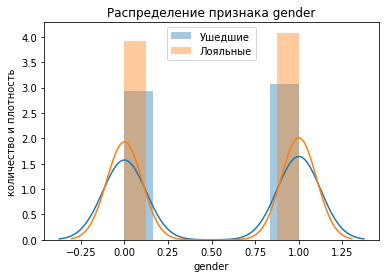

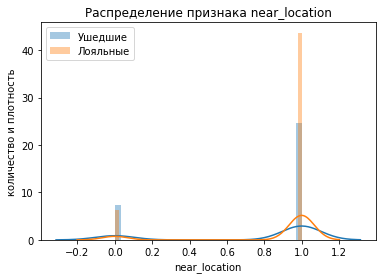

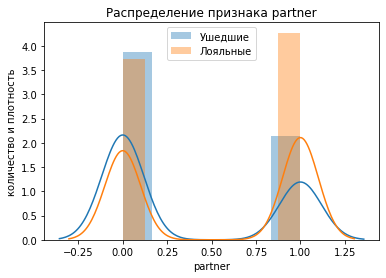

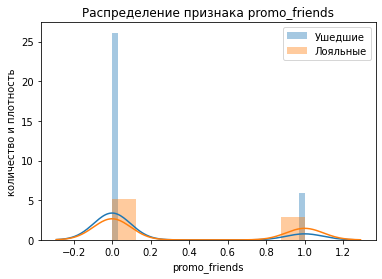

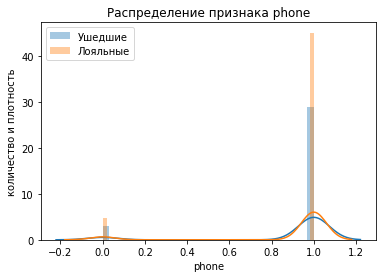

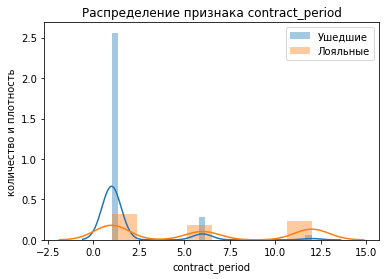

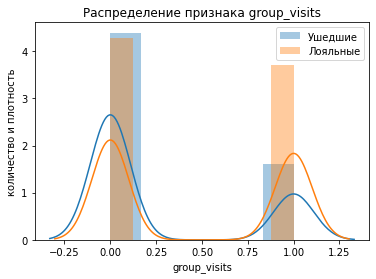

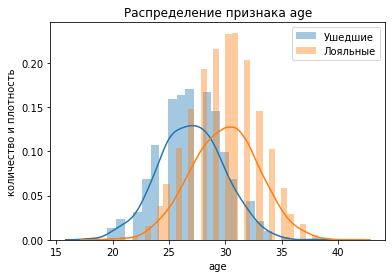

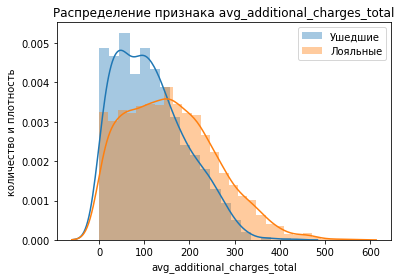

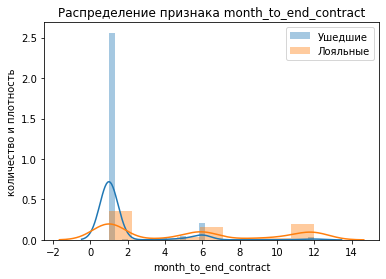

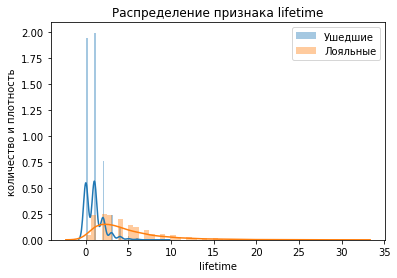

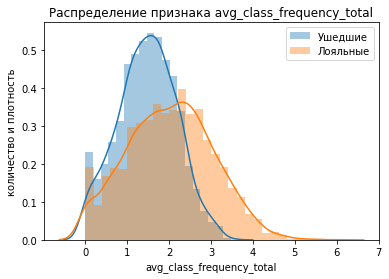

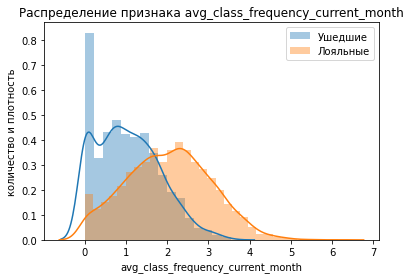

In [28]:
# Построим диаграммы распределения для каждого признака для ушедших и лояльных клиентов
fig, ax = plt.subplots()
for column in gym.drop('churn', axis = 1).columns:
    plt.title('Распределение признака '+column)
    plt.xlabel(column)
    plt.ylabel('количество и плотность')
    sns.distplot(churn_clients[column], label='Ушедшие')
    sns.distplot(loyal_clients[column], label='Лояльные')
    plt.legend()
    plt.show()

**Выводы:**    
1. По полу, близости к фитнес-центру, наличию контактного телефона обе группы имеют схожее равномерное распределение.   
1. Есть различия в распределении групп между теми, кто является сотрудником компании-партнёра клуба и не является. В группе лояльных клиентов число имеющих отношение к компании-партнёра сотрудников явно больше, чем среди тех, кто уходит в отток. 
1. Различия в распределении групп по посещению групповых занятий такие же, как и в распределениях по принадлежности к компании-партнёру.    
1. Среди тех, кто остался, по промо-акции "Приведи друга" клиентов немного больше, но распределения схожи.   
1. Распределение длительности действующего абонемента по оставшимся пользователям и ушедшим различается. Лояльных клиентов, приобретающих абонемент на 1 месяц больше всего, меньше их сроком на год, и наименьшее количество клиентов - на 6 месяцев. А для ушедших в отток 1 месяц - самый популярный, затем - 6 месяцев (с очень низким числом абонементов), и практически нет абонементов на 12 месяцев. Различия в распределении групп по сроку до окончания действующего абонемента такие же, как и в распределениях по длительности абонемента.   
1. По среднему возрасту обе группы имеют нормальное распределение, но распределение лояльных клиентов немного смещёно вправо (долее возрастные клиенты), а датасет ушедших клиентов - влево (более молодые).   
1. Распределение средней выручки от других услуг фитнес-центра для обоих датасетов смещено влево с большим смещением для ушедших людей. То есть те, кто уходит, практически ничего не тратят на дополнительные услуги в фитнес-центре.   
1. Распределение времени с момента первого обращения для обоих групп похоже на распределение Пуассона. Но для ушедших в отток клиентов оно сильно смещено влево, практически не имея значения в более высоких значениях, а для лояльных клиентов принимает более высокие значения.   
1. Распределение для средней частоты посещений в неделю за время действия абонемента в обоих группах является нормальным. Для лояльной группы оно немного смещено влево, а для группы уходящих в отток имеется сильное смещение влево. Аналогичные различия между группами наблюдаются и для распределений средней частоты посещений в неделю за месяц.   

### Матрица корреляций признаков<a id="corr"></a>

In [29]:
# Расчитаем кофициент корреляции между всеми признаками попарно
corr = gym.corr().round(2)
display(corr)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.00,0.01,-0.01,-0.01,-0.01,0.00,0.02,0.01,-0.01,-0.00,0.01,0.01,0.01,0.00
near_location,0.01,1.00,-0.01,0.21,-0.02,0.15,0.15,0.06,0.04,0.14,0.07,0.04,0.06,-0.13
partner,-0.01,-0.01,1.00,0.45,0.01,0.31,0.02,0.05,0.02,0.29,0.06,0.02,0.05,-0.16
promo_friends,-0.01,0.21,0.45,1.00,0.00,0.24,0.12,0.05,0.04,0.24,0.07,0.03,0.05,-0.16
phone,-0.01,-0.02,0.01,0.00,1.00,-0.01,-0.01,-0.01,0.01,-0.01,-0.02,0.01,0.01,-0.00
contract_period,0.00,0.15,0.31,0.24,-0.01,1.00,0.17,0.14,0.11,0.97,0.17,0.10,0.16,-0.39
group_visits,0.02,0.15,0.02,0.12,-0.01,0.17,1.00,0.08,0.03,0.16,0.08,0.06,0.08,-0.18
age,0.01,0.06,0.05,0.05,-0.01,0.14,0.08,1.00,0.08,0.13,0.16,0.12,0.18,-0.40
avg_additional_charges_total,-0.01,0.04,0.02,0.04,0.01,0.11,0.03,0.08,1.00,0.11,0.08,0.04,0.08,-0.20
month_to_end_contract,-0.00,0.14,0.29,0.24,-0.01,0.97,0.16,0.13,0.11,1.00,0.16,0.09,0.15,-0.38


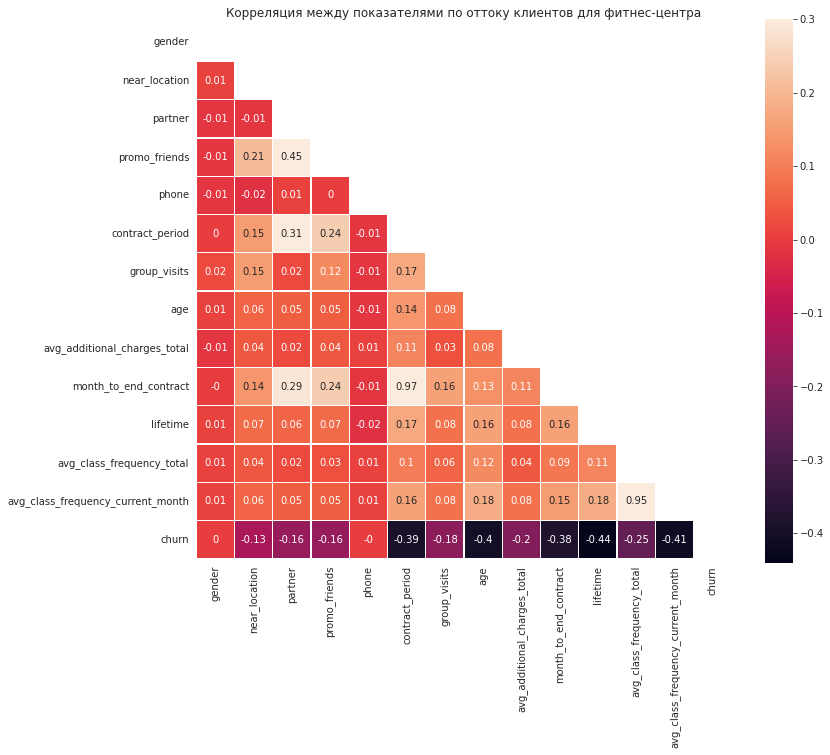

In [30]:
# Построим тепловую карту
mask = np.zeros_like(corr) # Создадим маску чтобы скрыть зеркальную часть
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 10))
    plt.title('Корреляция между показателями по оттоку клиентов для фитнес-центра')
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True, linewidths=.3)

**Выводы:**   
1. На основе корреляции мы видим, что такие признаки как пол и наличие контактного телефона почти не влияют на конечный показатель оттока. Все остальные показатели имеют обратное влияние: слабое, либо чуть более сильное. Явно влияющих признаков, сильно связанных с результирующим показателем, предварительный анализ не выделил.   
1. Также отметим, что имеется сильная связь (кофф.коррелиции - 0.97) между показателями длительности абонемента и количеством месяцев до конца абонемента. Это говорит о том, что в выборке представлены клиенты, которые отобраны на определённом этапе покупки абонемента. Скорее всего, в начале действия абонемента. Также наблюдается сильная связь (0.95) между средней частотой посщений в неделю с начала пользования услугами и за предыдущий месяц. Это говорит о другой зависимости: скорее всего, клиенты посещают фитнес-центр примерно одинаковое число раз в неделю вне зависимости от того, сколько они пользуются услугами центра.   
    
Для того, чтобы такие признаки не доминировали над остальными переменными при обучении, удалим из модели month_to_end_contract и avg_class_frequency_total.

In [31]:
# Удалим из модели month_to_end_contract и avg_class_frequency_total
gym = gym.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis=1)

### Выводы<a id="summary_3"></a>

**Анализ показателей:**
1. *Отток клиентов*. У нас есть данные о клиентах, которые продолжают пользоваться услугами фитнес-центра (лояльные клиенты) и тех, кто "ушёл" (нелояльные клиенты). При этом в выборке больше тех, кто продолжает пользоваться услугами (средняя близка к 0,3, а медиана равна 0).   
1. *Пол клиентов*. У нас имеются данные о мужчинах и женщинах. При этом в выборке их равное количество (средняя близка к 0,5, а медианное значение равно 1). Для уходящих в отток клиентов и остающихся распределения этого признака имеют схожий вид.  
1. *Близость к фитнес-центру*. У нас имеются данные о людях, которые живут или работают рядом с фитнес-центром, либо в отдалённости от него. При этом в выборке больше тех, кто живёт или работает рядом (так как средняя близка к 0,85, а первый квартиль равен 1). А в группе, которая лояльна к фитнес-центру, чуть больше человек, которые живут или работают поблизости, чем тех, кто находится в отдалённости. Однако, распределения по этому признаку для лояльных и нелояльных клиентов не сильно отличаются друг от друга.   
1. *Сотрудники компании-партнёра*. Данные о людях, которые являются или не являются сотрудниками компании-партнёра клуба, представлены в выборке примерно в равной пропорции (средняя близка к 0,5). Есть различия в оттоке между теми, кто является сотрудником компании-партнёра клуба. Среди тех, кто остался примерно половина и тех, кто связан с партнёрами, и тех, кто не связан, с небольшим преобладанием первых. Но из тех, кто ушёл в отток, больше клиентов, не связанных с компанией-партнёром. Это же выражено и в распределении соответствующих данных.   
1. *Промо-акция*. У нас имеются данные о людях, которые приобрели или не приобрели первый абонемент по акции "Приведи друга". При этом в обеих группах больше людей, которые приобрели первый абонемент не по промо-акции "Приведи друга" (так как средняя близка к 0,3, а медиана равна 0). Но среди тех, кто остался, пришедших по промо-акции больше, хотя распределения у лояльных клиентов и ушедших близки.   
1. *Контактный телефон*. В имеющихся данных по клиентам либо есть данные о контактном телефоне, либо их нет. При этом в выборке больше тех, для кого представлена контактная информация (так как средняя близка к 0,9, а четвёртый квартиль равен 1) для обоих категорий: лояльных и нелояльных клиентов (распределения схожи).   
1. *Возраст клиентов*. У нас имеются данные о клиентах возрастом от 18 до 41 года (при этом нет клиентов в возрасте 40 лет). Средний возраст равен 29 годам. При этом люди разного возраста выбраны достаточно равномерно (так как средняя близка к медиане, распределение для лояльных и нелояльных клиентов нормальное, а стандартное отклонение очень низкое). Распределение для лояльных клиентов немного смещено вправо, а для ушедших клиентов - влево. Так, в группе лояльных фитнес-центру людей средний возраст составляет около 30 лет, а среди уходящих - около 27 лет. То есть вторая группа чуть младше.   
1. *Время с первого обращения*. У нас имеются данные о клиентах, которые обращались в фитнес-центр впервые от 0 до 31 месяца назад (при этом нет клиентов, у которых прошло 25, 28 или 30 месяцев с момента первого обращения). Среднее время с момента первого обращения составляет 3 месяца. При этом есть перекос в данных, так как среднее значение ближе к 4 месяцам. Распределение времени с момента первого обращения для обоих групп (лояльных и нелояльных) похоже на распределение Пуассона. Но для ушедших в отток клиентов оно сильно смещено влево, практически не имея значения в более высоких значениях, а для лояльных клиентов принимает более высокие значения. Таким образом, среднее время с момента первого обращения для уходящих в отток составило 1 месяц, а для тех, кто остался, близко к 5 месяцам. Клиенты, проявляющие в первые месяцы лояльность, скорее всего, не уйдут в отток после длительного периода пользования услугами фитнес-центра.   
1. *Длительность абонемента*. Действующий абонемент по рассматриваемым клиентам имеет срок в 1, 6 и 12 месяцев (в выборку не попали клиенты, у которых срок составляет 3 месяца). Средняя длительность действующего абонемента составляет 4-5 месяцев. При этом есть перекос в данных: для большинства срок действующего абонемента равен 1 месяцу. Длительность действующего абонемента по оставшимся пользователям в среднем около 5-6 месяцев, а по ушедшим - 1-2 месяца. Это говорит о том, что купившие длительный абонемент с большей неохотой уйдут в отток, чем те, у кого он действует на короткий срок.   
1. *Время до окончания абонемента*. У нас имеются данные по клиентам, до окончания абонементов которых осталось от 1 до 12 месяцев. В среднем это значение около 4 месяцев. При этом больше половины всей выборки - это люди, до конца абонементов которых остался 1 месяц. Различия в распределении групп (лояльных и нелояльных клиентов) по сроку до окончания действующего абонемента такие же, как и в распределениях по длительности абонемента. В среднем срок до окончания действующего абонемента у людей, ушедших в отток, около 1-2 месяцев, а у оставшихся клиентов - около 5 месяцев. Это снова указывает на то, что уходят в большей степени те, у кого длительность оставшегося абонемента невысока.   
1. *Групповые занятия*. У нас есть данные о клиентах, которые посещают групповые занятия или не посещают. При этом в выборке чуть больше тех, кто не посещает такие занятия (средняя близка к 0,4, а медиана равна 0). При этом среди лояльных клиентов распределение посещающих такие занятия и непосещающих примерно равномерно (вторых чуть больше); но среди тех, кто ушёл в отток, непосещающих групповые занятия значительно больше, чем тех, кто их посещает.   
1. *Частота посещений за весь срок*. У нас имеются данные по клиентам со средней частотой посещений за все время с начала действия абонемента от 0 до 6 раз в неделю. В среднем это значение составляет около 2 раз в неделю. При этом выборка равномерная, так как среднее почти равно медиане, а стандартное отклонение невысоко. Распределение для средней частоты посещений в неделю за время действия абонемента в обоих группах (лояльные и нелояльные клиенты) является нормальным. Для лояльной группы оно немного смещено влево, а для группы уходящих в отток имеется сильное смещение влево. Лояльные клиенты, в среднем, посещают центр 2 раза в неделю, а ушедшие - от 1 до 2.   
1. *Частота посещений за месяц*. У нас имеются данные по клиентам со средней частотой посещений за месяц от 0 до 6 раз в неделю. В среднем это значение составляет около 2 раз в неделю. Распределения и средние значения схожи с распределениями аналогичного показателя за весь срок абонемента.   
1. *Выручка от прочих услуг*. Выручка от прочих услуг фитнес-центра с клиента составила от 0,15 до 552,6 ден.ед. В среднем это значение составляет около 147 ден.ед., медиана равна 136 ден.ед. Разброс данных очень большой (мы не знаем наверняка, в каких ден.ед. измеряются данные). Средняя выручка от других услуг фитнес-центра между группами разнится на 43 ден.ед. (в группе лояльных она выше, чем в группе уходящих). Распределение средней выручки от других услуг фитнес-центра для обоих датасетов смещено влево с большим смещением для ушедших людей. То есть те, кто уходит, стараются минимизировать затраты на дополнительные услуги в фитнес-центре.   

**Анализ коррелиции**   
1. На основе корреляции мы видим, что такие признаки как пол и наличие контактного телефона почти не влияют на конечный показатель оттока.   
1. Все остальные показатели имеют обратное влияние: слабое, либо чуть более сильное. Явно влияющих признаков, тесно связанных с результирующим показателем, предварительный анализ не выявил.   
1. Отметим, что имеется сильная связь между показателями длительности абонемента и количеством месяцев до конца абонемента. Это говорит о том, что в выборке представлены клиенты, которые отобраны на определённом этапе покупки абонемента. Скорее всего, в начале действия абонемента.   
1. Также наблюдается сильная связь между средней частотой посщений в неделю с началап пользования услугами и за предыдущий месяц. Это говорит о другой зависимости: скорее всего, клиенты посещают фитнес-центр примерно одинаковое число раз в неделю вне зависимости от того, сколько они пользуются услугами центра.

---

## Построение модели прогнозирования оттока пользователей<a id="model"></a>

### Выделение обучающей и валидационной выборок<a id="selection"></a>

In [32]:
# Разделим данные на признаки (матрица x) и целевую переменную (y)
x = gym.drop('churn', axis = 1)
y = gym['churn']

# Разделим выборку на обучающую и валидационную
# на 80% будем обучать модель, а на 20% - проверять
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

# Cтандартизируем данные
scaler = StandardScaler()
scaler.fit(x_train)
x_train_st = scaler.transform(x_train)
x_test_st = scaler.transform(x_test)

### Обучение моделей<a id="training"></a>

**Логистическая регрессия**

In [33]:
# Зададим алгоритм для модели
logreg_model = LogisticRegression(random_state=0)

# Обучим модель
logreg_model.fit(x_train_st, y_train)

# Воспользуемся обученной моделью, чтобы сделать прогнозы
logreg_predictions = logreg_model.predict(x_test_st)
logreg_probabilities = logreg_model.predict_proba(x_test_st)[:,1]

**Случайный лес**

In [34]:
# Зададим алгоритм для модели
randfor_model = RandomForestClassifier(random_state=0)

# Обучим модель
randfor_model.fit(x_train_st, y_train)

# Воспользуемся обученной моделью, чтобы сделать прогнозы
randfor_predictions = randfor_model.predict(x_test_st)
randfor_probabilities = randfor_model.predict_proba(x_test_st)[:,1]

### Оценка метрик и сравнение моделей<a id="metrics"></a>   
   
Создадим функцию для расчёта метрик:   
* accuracy (доля правильных ответов);    
* precision (точность);    
* recall (полнота);   
* ROC_AUC (метрика оценки качества классификатора).

In [35]:
# Определим функцию, которая будет выводить наши метрики
def print_metrics(y_true, y_pred, y_proba, model_name):
    print("Метрики для модели "+model_name)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [36]:
# Рассчитаем метрики для модели логистической регрессии
print_metrics(y_test, logreg_predictions, logreg_probabilities, 'логистической регрессии')
print()
# Рассчитаем метрики для модели случайного леса
print_metrics(y_test, randfor_predictions, randfor_probabilities, 'случайного леса')

Метрики для модели логистической регрессии
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.84
	ROC_AUC: 0.97

Метрики для модели случайного леса
	Accuracy: 0.91
	Precision: 0.85
	Recall: 0.77
	ROC_AUC: 0.96


**Вывод** Обе модели достаточно хорошо способны делать прогноз. Однако, модель логистической регрессии подходит больше по всем показателям: доле правильных ответов (accuracy), точности (precision) и наиболее точной метрике оценки качества классификатора ROC_AUC.

### Выводы<a id="summary_4"></a>

1. При построении модели мы разделили выборку на обучащую и валидационную в соотношении 80 к 20, то есть на 80% данных модель была обучена, а на 20% - проверена. После этого были построены и обучены 2 модели: алгоритмом логистической регрессии и алгоритмом случайного леса.   
    
1. Основные метрики полученных моделей следующие.   
  
Для модели логистической регрессии:   
* Accuracy = 0,92;   
* Precision = 0,85;   
* Recall = 0,84;   
* ROC_AUC = 0,97. 

Для модели случайного леса:   
* Accuracy = 0,91;   
* Precision = 0,85;    
* Recall = 0,77;   
* ROC_AUC = 0,96.  
3. Таким образом, обе модели достаточно хорошо способны делать прогноз. Однако, модель логистической регрессии подходит больше по всем показателям: доле правильных ответов (accuracy), точности (precision), полноте (recall) и метрике оценки качества классификатора ROC_AUC.

---

## Кластеризация пользователей<a id="clustering"></a>

### Стандартизация данных<a id="standardization"></a>

In [37]:
# Стандартизируем данные
scaler = StandardScaler()
x_st = scaler.fit_transform(x)

### Построение матрицы расстояний и дендрограммы<a id="matrix"></a>

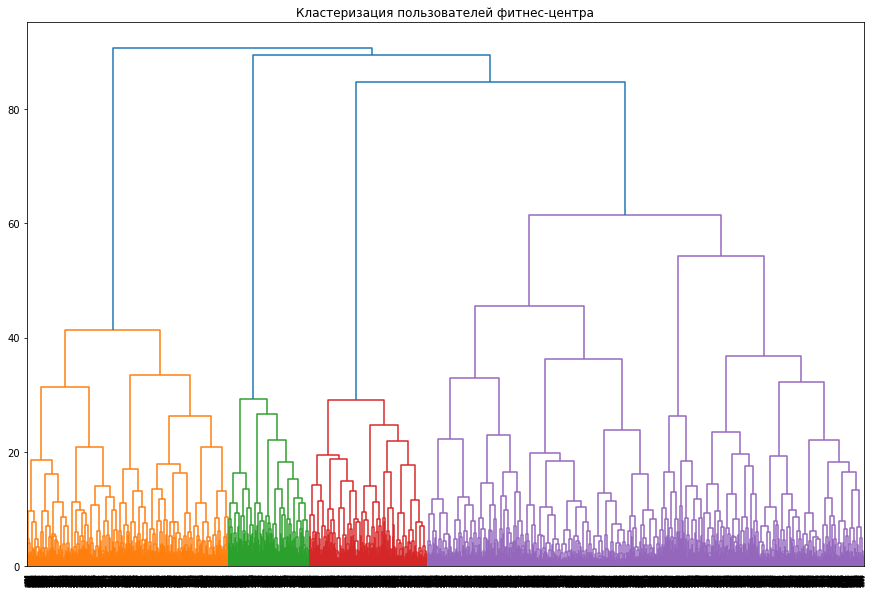

CPU times: user 1min 42s, sys: 10 s, total: 1min 52s
Wall time: 1min 59s


In [38]:
%%time
# Создадим матрицу расстояний
links = linkage(x_st, method = 'ward')

# Построим дендрограмму
plt.figure(figsize=(15, 10))
plt.title('Кластеризация пользователей фитнес-центра')
dendrogram(links, orientation='top')
plt.show()

**Вывод** По дендрограмме можно предположить наличие четырёх кластеров в данных.   
Было принято решение для прогноза кластеров клиентов использовать пять кластеров - т.к. правый кластер на дендограмме  слишком большой по сравнению с другими - возможно его стоит разбить. Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.  

### Обучение модели кластеризации и прогноз кластеров клиентов<a id="clust_training"></a>

In [39]:
# Зададим модель k_means с числом кластеров 5
km = KMeans(n_clusters = 5, random_state=0)

# Спрогнозируем кластеры для наблюдений
labels = km.fit_predict(x_st)

# Сохраним метки кластера в поле нашего датасета
gym['cluster_km'] = labels

# Переименуем названия кластеров
gym.loc[gym['cluster_km']==0, 'cluster_km'] = 'cluster_1'
gym.loc[gym['cluster_km']==1, 'cluster_km'] = 'cluster_2'
gym.loc[gym['cluster_km']==2, 'cluster_km'] = 'cluster_3'
gym.loc[gym['cluster_km']==3, 'cluster_km'] = 'cluster_4'
gym.loc[gym['cluster_km']==4, 'cluster_km'] = 'cluster_5'

# Выведем средние значения признаков для кластеров
display(gym.groupby('cluster_km').mean().round(2))

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,
cluster_1,0.50,1.00,0.89,1.00,1.0,6.92,0.52,29.61,153.42,4.28,1.92,0.12
cluster_2,0.50,0.00,0.49,0.08,1.0,2.99,0.23,28.68,137.13,2.97,1.60,0.40
cluster_3,0.50,1.00,0.22,0.07,1.0,2.01,0.28,27.58,119.34,1.92,1.20,0.56
cluster_4,0.53,1.00,0.38,0.01,1.0,6.21,0.54,30.70,176.26,5.42,2.32,0.01
cluster_5,0.52,0.86,0.47,0.31,0.0,4.78,0.43,29.30,144.21,3.94,1.72,0.27


**Вывод** При взгляде на таблицу чётко отделяемые группы выделить можно по ряду признаков. Однако, для более наглядного разделения требуется построить распределение для каждого признака по кластерам.

### Анализ распределения признаков для кластеров<a id="features"></a>   
   
Для анализа распределения признаков в кластерах построим столбчатые диаграммы для логических и дискретных переменных (пол, близость к фитнес-центру, принадлежность к компании-партнёру, первое посещение по акции "Приведи друга", наличие контакта, длительность абонемента, посещение групповых занятий, отток) и боксплоты для непрерывных переменных (возраст, время с момента первого обращения, показатели средней частоты посещений в неделю за месяц, выручка от других услуг).

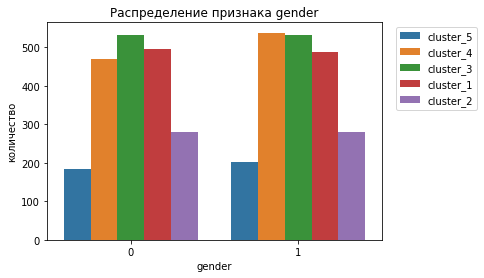

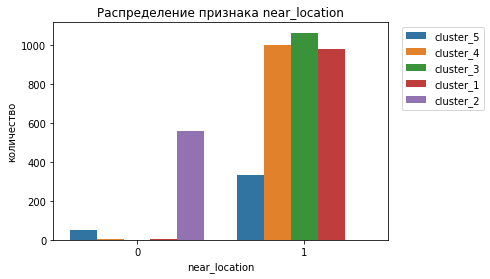

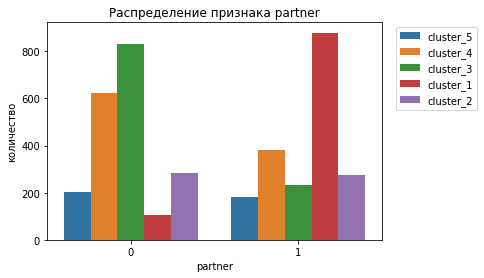

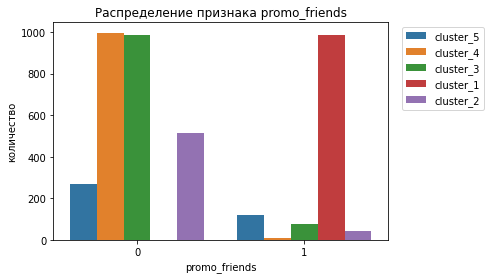

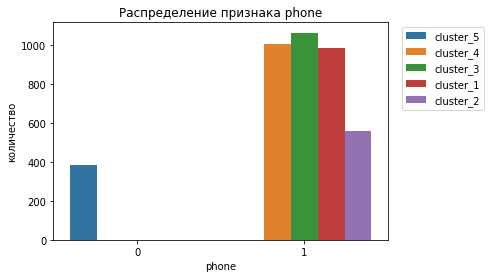

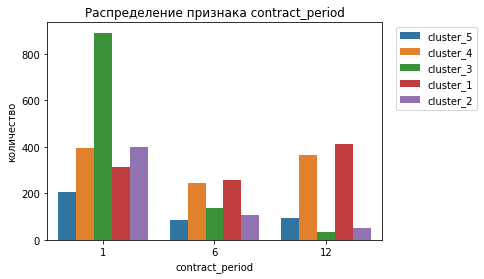

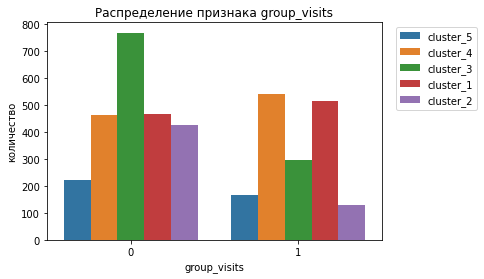

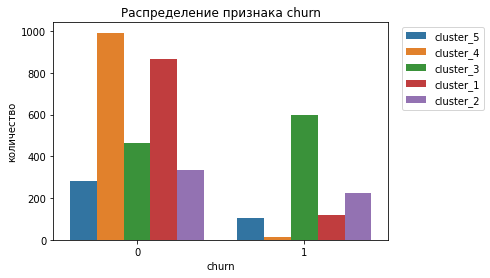

In [40]:
# Построим график для логических и дискретных величин
log_discr_values = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits', 'churn']
fig, ax = plt.subplots()
for column in log_discr_values:
    plt.title("Распределение признака "+column)
    sns.countplot(data=gym, x=column, hue='cluster_km')
    plt.xlabel(column)
    plt.ylabel("количество")
    plt.legend(bbox_to_anchor=(1.3, 1))
    plt.show()

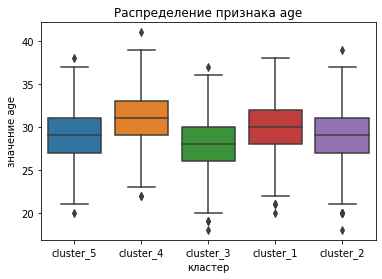

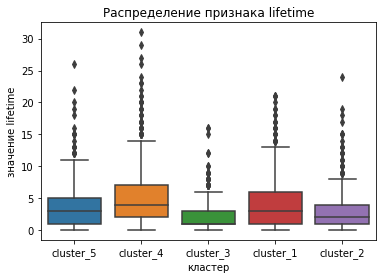

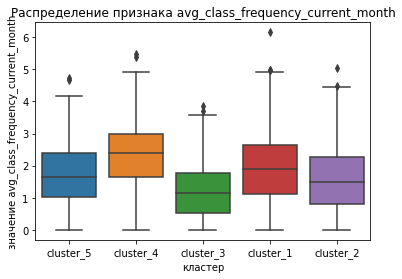

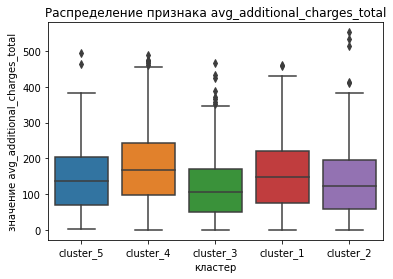

In [41]:
# Построим график для непрерывных величин
cont_values = ['age', 'lifetime', 'avg_class_frequency_current_month', 'avg_additional_charges_total']
fig, ax = plt.subplots()
for column in cont_values:
    plt.title("Распределение признака "+column)
    sns.boxplot(x='cluster_km', y=column, data=gym)
    plt.xlabel('кластер')
    plt.ylabel('значение '+column)
    plt.show()

Каждый из получившихся у нас кластеров мы охарактеризуем в параграфе с выводами по разделу 5. 
   


### Расчёт и анализ долей оттока для кластеров<a id="shares"></a>

In [42]:
# Для каждого полученного кластера посчитаем долю оттока
display(gym
     .groupby('cluster_km')['churn']
     .mean()
     .round(2)
     .reset_index()
     .sort_values(by='churn', ascending=False)
     .reset_index(drop=True))

,cluster_km,churn
0,cluster_3,0.56
1,cluster_2,0.40
2,cluster_5,0.27
3,cluster_1,0.12
4,cluster_4,0.01


**Вывод** Третий кластер больше всего склонен к оттоку: доля составляет 56%. Втрой кластер характеризуется долей оттока в 40%, а пятый - 27%. Первый и четвёртый кластеры (доля оттока 12% и 2%, соответственно) являются самыми лояльными.

### Выводы<a id="summary_5"></a>

Охарактеризуем каждый из получившихся у нас кластеров. 
 
**Кластер 1 характеризуется:**  
* приблизительно равным распределением между мужчинами и женщинами;   
* клиентами, которые находятся поблизости от фитнес-центра;   
* клиентами, большинство из которых (около 80%) пришли не от компаний-партнёров;   
* клиентами, которые пришли не по промо-акции от друзей;  
* наличием контактных данных;   
* абонементом на 1, 6 и 12 месяцев со значительным преобладанием абонементов на 1 месяц;   
* клиентами, около 30% которых посещает групповые занятия;   
* средним возрастом около 27,5 лет;  
* низким уровнем дополнительных оплат;   
* коротким сроком от начала пользования услугами;   
* посещением около 1 раза в неделю.  
   
**Кластер 2 характеризуется:**   
* приблизительно равным распределением между мужчинами и женщинами;   
* клиентами, которые находятся поблизости от фитнес-центра;   
* клиентами, большинство из которых (около 90%) пришло от компаний-партнёров;   
* клиентами, большинство из которых (около 70%) пришло не по промо-акции от друзей;   
* наличием контактных данных;   
* абонементом на 1, 6 и 12 месяцев с примерно равным распределением и небольшим преобладанием 12 месяцев;   
* клиентами, около половины которых посещает групповые занятия;   
* средним возрастом около 29,5 лет;   
* высоким уровнем дополнительных оплат;   
* средним сроком от начала пользования услугами;   
* посещением около 2 раз в неделю.   
   
**Кластер 3 характеризуется:**   
* приблизительно равным распределением между мужчинами и женщинами;   
* клиентами, большинство из которых находится вблизи от фитнес-центра;   
* примерно равным числом посетителей от компаний-партнёров и обычных посетителей;   
* клиентами, большинство из которых (около 70%) пришло не по промо-акции от друзей;   
* отсутствием контактных данных;   
* абонементом на 1, 6 и 12 месяцев с примерно равным распределением и небольшим преобладанием 1 месяца;   
* клиентами, около 40% которых посещает групповые занятия;    
* средним возрастом в 29-29,5 лет;   
* средним уровнем дополнительных оплат;   
* средним сроком от начала пользования услугами;   
* посещением около 1,5-2 раз в неделю.   
   
**Кластер 4 характеризуется:**    
* приблизительно равным распределением между мужчинами и женщинами;   
* клиентами, живущими или работающими вдали от фитнес-центра;   
* примерно равным числом посетителей от компаний-партнёров и обычных посетителей;   
* клиентами, большинство из которых (около 75%) пришло не по промо-акции от друзей;   
* наличием контактных данных;   
* абонементом на 1, 6 и 12 месяцев с преобладанием 1 месяца;   
* клиентами, около 25% которых посещает групповые занятия;   
* средним возрастом около 28,5 лет;   
* средним уровнем дополнительных оплат;   
* небольшим сроком от начала пользования услугами;   
* посещением около 1,5 раз в неделю.   
     
**Кластер 5 характеризуется:**   
* чуть большим числом людей одного пола, по сравнению с другим;   
* клиентами, которые находятся вблизи от фитнес-центра;   
* клиентами, большинство из которых (около 65%) пришли не от компаний-партнёров;   
* клиентами, которые пришли не по промо-акции от друзей;   
* наличием контактных данных;   
* абонементом на 1, 6 и 12 месяцев с примерно равным распределением и чуть меньшим количеством 6 месяцев;   
* клиентами, около половины которых посещает групповые занятия;   
* средним возрастом около 30,5 лет;   
* очень высоким уровнем дополнительных оплат;   
* длительным сроком от начала пользования услугами;   
* посещением около 2-2,5 раз в неделю.   
  
Третий кластер больше всего склонен к оттоку: доля составляет 56%. Втрой кластер характеризуется долей оттока в 40%, а пятый - 27%. Первый и четвёртый кластеры (доля оттока 12% и 2%, соответственно) являются самыми лояльными.

---

## Выводы и рекомендации<a id="summary"></a>

Было проведено исследование данных о клиентах фитнес-центра «Культурист-датасаентист». Эти данные содержат в себе информацию о 4000 клиентов и 14 показателях, один из которых (отток клиентов выбран в модели в качестве результирующего). Анализируемыми показателями, которые влияют на отток выбраны следующие характеристики клиентов: пол, близость к фитнес-центру, принадлежность к компании-партнёру фитнес-центра, факт первоначальной записи в рамках промо-акции «приведи друга», наличие контактного телефона, возраст, время с момента первого обращения в фитнес-центр, длительность текущего действующего абонемента, срок до окончания действующего абонемента, факт посещения групповых занятий, средняя частоа посещений в неделю за все время с начала действия абонемента и за предыдущий месяц, суммарная выручка от других услуг фитнес-центра.   
  
**ВЫВОДЫ**

**Анализ данных позволил сделать следующие выводы:**   
    
* Средняя по оттоку клиентов близка к 0,3, а медиана равна 0.   
* Соответственно, около трети клиентов фитнес-центра уходит в отток.   
* Средняя по полу клинтов близка к 0,5, а медиана равна 1 - услугами фитнес-центра пользуются в равной степени мужчины и женщины.   
* Средняя по близости к фитнес-центру близка к 0,85, а первый квартиль равен 1. Распределения по признаку не сильно отличаются. Среднее значение для лояльных клиентов чуть выше, чем для людей, уходящих в отток.Таким образом, фитнес-центр посещает больше клиентов, которые живут поблизости. При этом немного лояльнее к фитнес-центру те, кто живёт поблизости, чем те, кто живёт в отдалении.   
* Средняя по принадлежности к компании-партнёру близка к 0,5. Распределения для ушедших в отток и оставшихся клиентов ведут себя по-разному. Так, в фитнес-центре в равной степени представлены клиенты, являющиеся сотрудниками компаний-партнёров, и люди, не имеющие к ним отношение. Но ушедшие в отток клиенты в большей степени не являются сотрудниками компаний-партнёров.   
* Средняя по пришедшим по промо-акции "Приведи друга" равна 0,3, медиана равна 0. Распределения для ушедших в отток и лояльных клиентов близки, но средние значения немного отличаются (для второй группы значение выше). Соответственно, большинство клиентов фитнес-центра не пришло по промо-акции "Приведи друга", но среди лояльных клиентов воспользовавшихся акцией больше, чем среди уходящих в отток.    
* Средняя по наличию контактного телефона близка к 0,9, а четвёртый квартиль равен 1. Распределения по лояльным и нелояльным клиентам имеют схожий вид. Тамим образом, практически все клиенты фитнес-центра оставляют контакты для связи - вне зависимости от того, останутся они в фитнес-центре, или уйдут в отток.   
* Минимальное значение возраста равно 18, максимальное - 41, среднее - 29. Среднее значение близко к медиане, стандартное отклонение очень низкое, распределение для лояльных и нелояльных клиентов нормальное. Распределение для лояльных клиентов немного смещено вправо со средней в 30, а для ушедших клиентов - влево со средней в 27. Соответственно, услугами фитнес-центра пользуются клиенты возрастом от 18 до 41 года (со средним возрастом около 29 лет). Причём в отток в дальнейшем уходят клиенты более молодого возраста (около 27 лет).   
* Минимальное значение времени с первого обращения равно 0, максимальное - 31, среднее - 3, медиана близка к 4 месяцам. Распределение времени с момента первого обращения для обоих групп (лояльных и нелояльных) похоже на распределение Пуассона. Но для ушедших в отток клиентов оно сильно смещено влево (со средним в 1 месяц), практически не имея значения в более высоких значениях, а для лояльных клиентов принимает более высокие значения (со средним в 5 месяцев). Таким образом, в фитнес центре есть "новенькие" клиенты (которые несколько месяцев пользуются услугами центра) и "опытные" клиенты (которые достаточно давно начали посещать фитнес-центр). При этом клиенты, проявляющие уже в первые несколько месяцев лояльность к фитнес-центру, скорее всего, не уйдут в отток в последующие месяцы.   
* Показатель длительности абонемента может принимать значения 1, 6 и 12 месяцев. Среднее значение равно 4-5 месяцев. При этом есть перекос в данных: медиана равна 1 месяцу. Среднее значение для лояльных пользователей - 5-6 месяцев, для уходящих в отток - 1-2 месяца. Показатель времени до окончания абонемента принимает значения от 1 до 12 месяцев. Среднее значение равно 4 месяца, При этом есть перекос в данных: медиана равна 1 месяцу. Различия в распределении групп (лояльных и нелояльных клиентов) по сроку до окончания действующего абонемента такие же, как и в распределениях по длительности абонемента. Соответственно, клиенты предпочитают покупать абонемент на короткий срок, но купившие более длительный абонемент с большей неохотой уйдут в отток, чем те, у кого он действует короткий срок.   
* Средняя по посещаемости групповых занятий близка к 0,4, а медиана равна 0. Распределения по лояльным и уходящим в отток клиентам различаются. Так, среди клиентов фитнес-центра больше тех, кто не интересуется групповыми занятиями (около 60%). При этом уходящие в отток клиенты практически не заинтересованы в таких занятиях.    
* Средняя частота посещений за всё время с начала действия абонемента и за предыдущий месяц колеблются в промежутке от 0 до 6 раз в неделю. Среднее значение и медиана практически равны, стандартное отклонение невысоко. Распределение для лояльных и нелояльных групп является нормальным. Для лояльной группы оно немного смещено влево (среднее 1-2), а для группы уходящих в отток имеется сильное смещение влево (среднее около 2). Соответственно, в фитнес-центре есть люди, которые купили абонемент, но ни разу не посетили центр, а есть и очень "приверженные" клиенты (посещение 6 раз в неделю). При этом, в среднем, все клиенты посещают центр около 1-2 раз в неделю. Однако, среди лояльных клиентов много тех, кто часто посещает фитнес-центр.    
* Выручка с клиента от прочих услуг фитнес-центра сильно колеблется от 0,15 до 552,6 ден.ед. Среднее значение равно 147 ден.ед, а медиана - 136 ден.ед. Между группами (лояльные и нелояльные клиенты) различие в среднем значении составляет 43 ден.ед. (для лояльных значение выше). Распределение средней выручки от других услуг фитнес-центра для обоих датасетов смещено влево с большим смещением для ушедших людей. Таким образом, затраты на прочие услуги фитнес-центра очень сильно варьируются для клиентов. При этом уходящие в отток клиенты склонны экономить, а среди лояльных клиентов встречаются те, кто готов заплатить очень высокую цену.    
   
**Основные метрики полученных моделей, построенных алгоритмом логистической регрессии и алгоритмом случайного леса, следующие:**    
    
Для модели логистической регрессии:   
* Accuracy = 0,92;    
* Precision = 0,85;    
* Recall = 0,84;   
* ROC_AUC = 0,97. 
   
Для модели случайного леса:     
* Accuracy = 0,91;    
* Precision = 0,85;    
* Recall = 0,77;   
* ROC_AUC = 0,96.   
   
Таким образом, и модель логистической регрессии, и модель случайного леса достаточно хорошо способны делать прогноз. Однако, модель логистической регрессии подходит больше по всем показателям: доле правильных ответов (accuracy), точности (precision), полноте (recall), агрерующей метрике F1 и наиболее точной метрике оценки качества классификатора ROC_AUC.

**Кластерный анализ клиентов**   
По дендрограмме было высказано предположение о наличии четырёх кластеров в данных. Однако, было принято решение для прогноза кластеров клиентов использовать пять кластеров в модели K-Means.   
Анализ средних значений и распределений признаков для кластеров показал, что выделенные кластеры имеют следующие отличительные характеристики.    
   
**Кластер 1** - это клиенты, находящиеся поблизости от фитнес-центра, большинство из которых пришло не от компаний-партнёров и не по промо-акции от друзей, с абонементом на 1, 6 и 12 месяцев (со значительным преобладанием первых), для трети из которых групповые занятия важны, с низким уровнем дополнительных оплат, являющиеся нашими "новыми" клиентами, посещающие фитнес-центр около 1 раза в неделю. Для них доля оттока близка к 56% - это наиболее склонный к оттоку кластер.   

**Кластер 2** - это клиенты,находящиеся поблизости от фитнес-центра, большинство из которых пришло от компании-партнёров и не по промо-акции от друзей, с абонементом на 1, 6 и 12 месяцев в примерно равных пропорциях с небольшим преобладанием 12 месяцев, около половины которых посещает групповые занятия, с высоким уровнем дополнительных оплат, некоторое время являющиеся нашими клиентами, посещающие фитнес-центр около 2 раз в неделю. Для них доля оттока близка к 12% - это один из самых надёжных кластеров.   

**Кластер 3** - это клиенты, большинство из которых находится вблизи от фитнес-центра, пришедшие примерно в равных пропорциях от компаний-партнёров и не от них, большинство из них пришло не по промо-акции от друзей, без контактных данных, с абонементами на 1, 6 и 12 месяцев (с примерно равным распределением и небольшим преобладанием абонементов на 1 месяц), для большинства из которых (60%) групповые занятия не важны, со средним уровнем дополнительных оплат, некоторое время являющиеся нашими клиентами, посещающие фитнес-центр около 1,5-2 раз в неделю. Для них доля оттока близка к 27%.   

**Кластер 4**  - это клиенты, живущие или работающие вдали от фитнес-центра, пришедшие примерно в равных пропорциях от компаний-партнёров и не от них, большинство из них пришло не по промо-акции от друзей, с абонементами на 1, 6 и 12 месяцев (с преобладанием абонементов на 1 месяц), для большинства из которых групповые занятия не важны, со средним уровнем дополнительных оплат, небольшим сроком от начала пользования услугами, посещающие фитнес-центр около 1,5 раз в неделю. Для них доля оттока близка к 40% - это в очень большой степени склонный к оттоку кластер.   

**Кластер 5** - это клиенты с небольшим преобладанием людей одного пола, по сравнению с другим, которые живут или работают возле фитнес-центра, пришедшие в большинстве своём не от компаний-партнёров и не по промо-акции от друзей, с абонементами на 1, 6 и 12 месяцев (с примерно равным распределением 1 и 12 месяцев, и чуть меньшим количеством 6 месяцев), около половины из которых посещает групповые занятия, с очень высоким уровнем дополнительных оплат, являющиеся нашими постоянными "давними" клиентами, посещающие фитнес-центр около 2-2,5 раз в неделю. Для них доля оттока близка к 2% - это самый надёжный кластер.   
 
**РЕКОМЕНДАЦИИ**  
    
На основе представленных выводов, предложены следующие рекомендации для стратегии взаимодействия с пользователями сети фитнес-центров «Культурист-датасаентист» и их удержания.
1. Рекомендуется привлечение в фитнес-центр клиентов из близлежащих спальных районах.   
1. Рекомендуется отменить проведение акции "Приведи друга" и акций для сотрудников компаний-партнёров - поскольку они не способствует "удержанию" клиентов, а высвободившиеся деньги направить на другие мероприятия (например, раздача листовок в близлежащих спальных районах - п.1).   
1. Возможно внедрение и реклама абонементов более длительного срока (9 и 12 месяцев) - поскольку чем дольше времени до окончания абонемента, тем лояльнее клиенты.   
1. Поскольку категория с длительными абонементами имеет склонность пользоваться доп услугами, для них возможно введение специальных скидок и акций по доп услугам.   
1. Рекомендуется установить более выгодные цены на длительные абонементы. Например, цена на абонемент на 3 месяца (нужно внедрить абонементы на 3 месяца) ненамного дороже, чем на абонемент на 1 месяц (чтобы покупатель стремился покупать 3 месяца) - это снизит риски оттока клиентов в первые месяцы.   
1. Возможно ввести более выгодное продление абонемента для клиентов, покупающих абонемент сроком от 3 месяцев. Например, по окончании абонемента покупка нового тем же сроком - скидка 25%. Подобные скидки окупятся доп услугами, которыми пользуются лояльные клиенты и отменой неэффективных акций.     
1. Рекомендуется проводить мониторинг средней частоты посещений фитнес-центра в неделю по клиентам. При обнаружении снижения показателя предлагать клиентам "бонусы" (бесплатная разовая доп услуга, скидки на продление абонемента, одно бесплатное групповое занятие по новому для него направлению и т.п.).